Done by: Koh Aik Hong 1005139

In [1]:
from IPython.display import display, Image

# Gaussian Mixture Model [50 points]
Image segmentation is an important step towards scene understanding for autonomous systems. Figure 1 gives an example of image segmentation that decouples the image foreground from the background. The Gaussian mixture model (GMM) is one of the earliest approaches used for image segmentation.

When we formulate the image segmentation task as a Gaussian mixture model, we assume that there are K segments and each of them is modeled as a Gaussian distribution with $N (µ_k, Σ_k)$. These segments form a Gaussian mixture model with each segment weighted by a mixing weight $π_k$. We encapsulate these parameters into a parameter vector $θ = (π_1, . . . , π_K, µ_1, . . . , µ_K, Σ_1, ..., Σ_K)$.

Since we know neither the component from which each data point (each pixel) came, nor the parameters of each model, we use the EM algorithm to alternatively solve the parameter vector $θ$ in Expectation step (E-step) and Maximization step (M-step).

In the E-step, we compute the probability that a pixel comes from a segment based on the model parameters from M-step. In the first iteration, the model parameters are initialized randomly (Note that $π_k$ is initialized as $1/K$). In the M-step, we compute the parameters θ of every Gaussian model based on the probabilities from E-step.

**[Task Description]** You are required to use the EM algorithm in GMM to segment the foreground from the
background, i.e. the number of segments $K = 2$, for three testing images: ‘fox’, ‘owl’, and ’zebra’ (in the
./data folder). We use image colors in CIE-Lab color space as the observed data $x_i ∈ R^3$ for the image segmentation task.

- The input is a RGB image. You are provided with a data file in the text format (e.g., ‘fox.txt’), where each line gives you a coordinate and the corresponding Lab value.
- For each input image, you are required to generate three outputs: one mask image, one image with only the foreground, and one image with only background.
- You are given an example of the output images to check whether your result is reasonable, as shown in Figure 2. Note that your results might differ slightly from the example results due to the choice of the initial values of the parameters and the number of iterations. (This example result is also given in the data folder.)

**[Implementation]** You are also given the Python source code (io data.py) for file reading. You can use resources for mathematical operation, such as the determinant of a matrix, but you are not allowed to use any libraries or online codes for implementing the EM algorithm and Gaussian distribution. You need to write your own code to implement the EM algorithm, including parameter initialization, E-step and M-step, or convergence check (optional).

A helpful tip to remember is that if your method is experiencing slow convergence, you could try implementing a smart approach for parameter initialization. One potential method is to initialize the parameters $µ_k$ and $Σ_k$ within the range provided by the data.

**[Submission]** Please submit both your code and report.

1. (30 points) Submit your code together with crystal clear instructions to run the code (python version package versions, etc.). The code must be ready to run code without requiring any changes. The TA will follow the instructions to run your code and grade accordingly.
2. (10 points) Run your program on all the three images we provide to you and submit all the output results (see the example in Figure 2) in the report.
3. (10 points) In addition to the output results, you are required to briefly introduce your algorithm and equations in the report, e.g. which data feature(s) you use in EM.

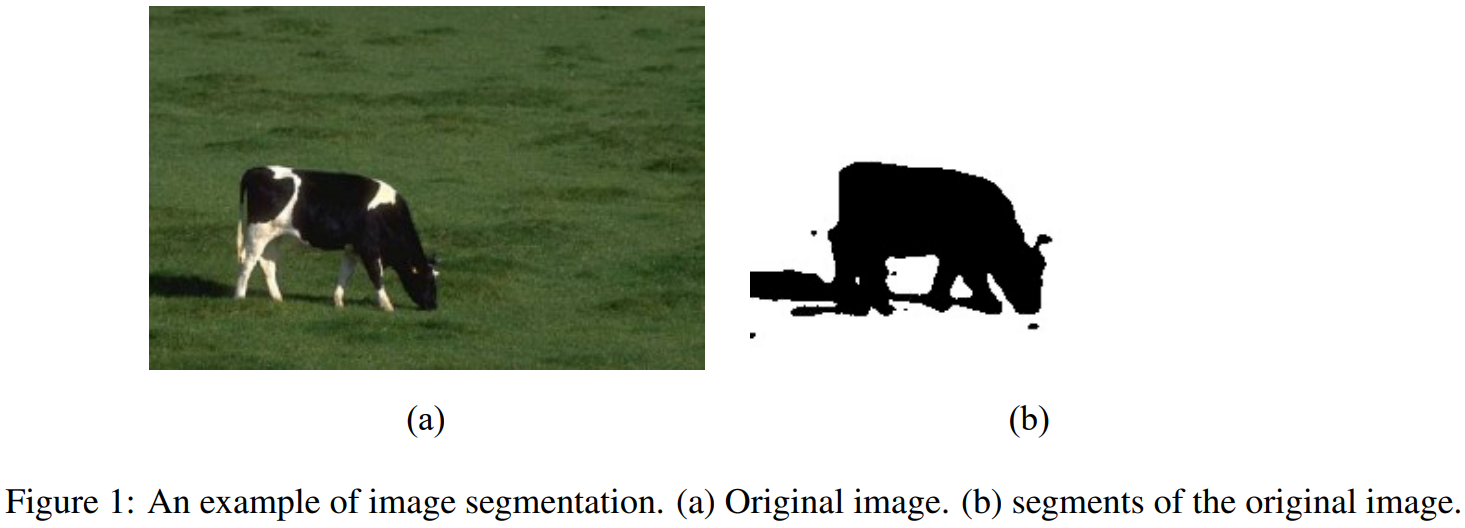

In [19]:
display(Image(filename="pics/fig1.png"))

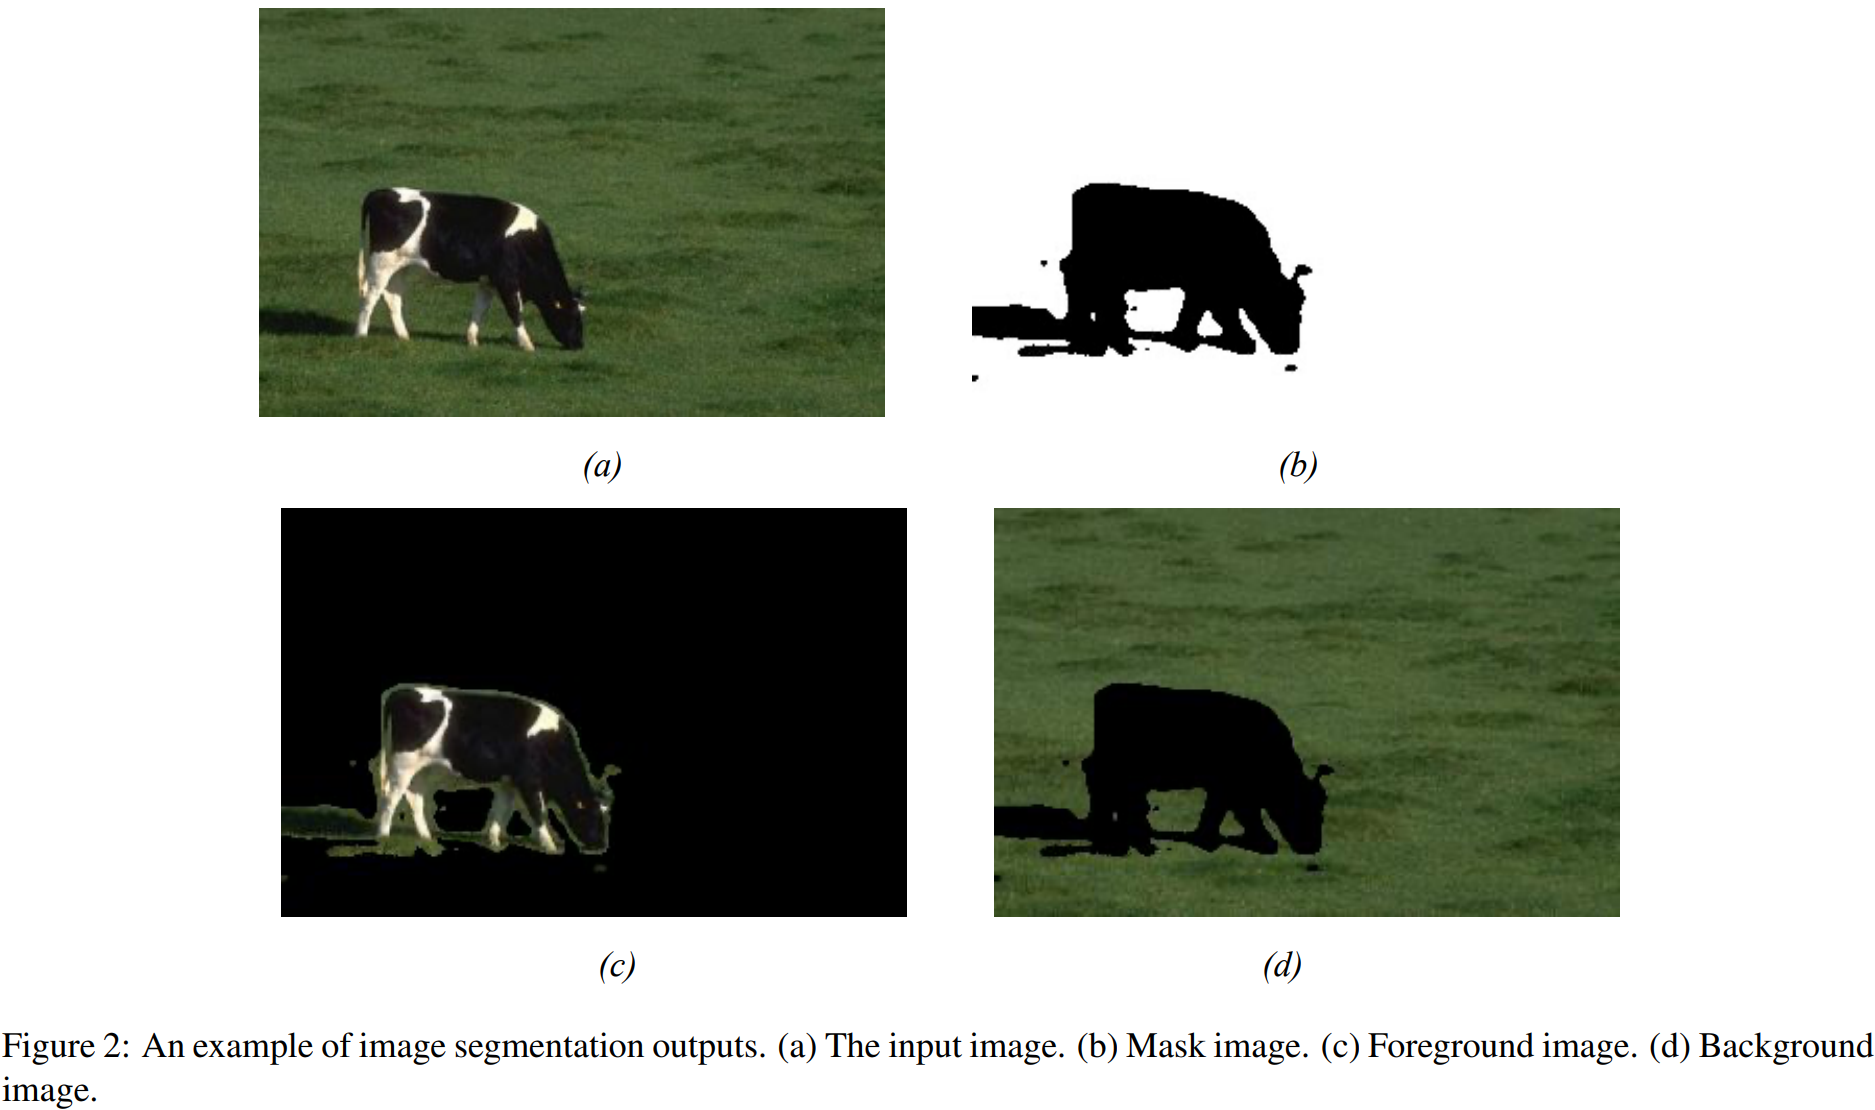

In [21]:
display(Image(filename="pics/fig2.png"))

## Question 1 Answer

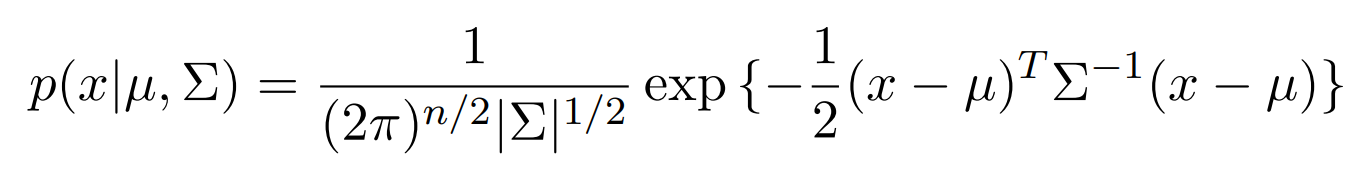

In [22]:
# source: https://www.cs.cmu.edu/~epxing/Class/10701-08s/recitation/gaussian.pdf
display(Image(filename="pics/multivariate_gaussan_distribution_eqn.png"))

In [5]:
import numpy as np
def multivariate_gaussian(X, cluster):
    dimensions = X.shape[1]
    mean = cluster[0]
    covar = cluster[1]
    likelihoods = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        likelihoods[i] = (1 / ((2.0 * np.pi)**(dimensions / 2) * np.linalg.det(covar)**0.5)) * np.exp(-0.5 * (x - mean).T @ np.linalg.inv(covar) @ (x - mean), dtype=np.float64 )
    return likelihoods

In [6]:
class GaussianMixtureModel:
    def __init__(self, k=2, max_iter=2000):
        self.k = k
        self.max_iter = max_iter
        self.current_cluster_assignment = None
        self.gamma = None
        self.past_gammas = []
        # stores all the parameters (mu and sigma) for each cluster (k x 2)
        self.clusters = []

    def intitialize_clusters(self, X):
        n = X.shape[0]
        # Initialize PIs to be all 1/k
        self.PIs = np.array([1 / self.k for i in range(self.k)])
        
        # split the data into k clusters
        splits = np.array_split(X, self.k)

        # initialize a random gaussian (mu and sigma) for each cluster
        for sub_array in splits:
            cluster = []
            cluster.append(sub_array.mean(axis=0))
            # using the formula in the slide, but initialize based on the sub_array's mean
            covariance_matrix = (1 / (n-1)) * (sub_array - sub_array.mean(axis=0)).T @ (sub_array - sub_array.mean(axis=0))
            cluster.append(covariance_matrix)
            self.clusters.append(cluster)

    def calc_likelihood(self, X):
        """ Calculate the likelihood over all samples """
        n = X.shape[0]
        likelihoods = np.zeros((n, self.k))
        for i in range(self.k):
            likelihoods[
                :, i] = multivariate_gaussian(
                X, self.clusters[i])
        return likelihoods

    def e_step(self, X):
        """
        Calculate the gamma
        """
        # Determine gamma using the formula in the slides
        top = self.PIs * self.calc_likelihood(X) # (n, k)
        # sum over all the clusters and convert it into a column vector
        bottom = np.expand_dims(
            np.sum(top, axis=1), axis=1)
        self.gamma = top / bottom
        # choose the assignment with the highest gamma value
        self.current_cluster_assignment = self.gamma.argmax(axis=1)
        # for checking if the model has converged
        self.past_gammas.append(np.max(self.gamma, axis=1))

    def m_step(self, X):
        """
        Update the MUs, SIGMAs and PIs
        """
        # update the mean and covariance for each cluster``
        for i in range(self.k):
            # retrieve the gamma values for the current cluster and convert it into a column vector
            cluster_gamma = np.expand_dims(self.gamma[:, i], axis=1)
            # using the formula in the sldes to calculate the mean
            new_mean = (1/cluster_gamma.sum()) * (cluster_gamma * X).sum(axis=0)
            # using the formula in the sldes to calculate the covariance
            new_covariance = (1/cluster_gamma.sum()) * (X - new_mean).T @ ((X - new_mean) * cluster_gamma)
            # update the cluster parameters
            self.clusters[i][0] = new_mean
            self.clusters[i][1] = new_covariance
        self.PIs = self.gamma.sum(axis=0) / X.shape[0]

    def has_converged(self, X):
        """
        Check if the change in gammas is less than the tolerance
        """
        if len(self.past_gammas) < 2:
            return False
        change = np.linalg.norm(
            self.past_gammas[-1] - self.past_gammas[-2])
        return change <= 1e-10

    def fit_and_predict(self, X):
        self.intitialize_clusters(X)
        for i in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            # Check convergence
            if self.has_converged(X):
                break
        # update the cluster assignment using the final parameters
        self.e_step(X)
        return self.current_cluster_assignment

In [7]:
def generate_white_mask(data, cluster_assignment):
    """ Generate a white mask for the image """
    mask = []
    majority_cluster = np.bincount(cluster_assignment).argmax()
    for x,y in zip(data, cluster_assignment):
        if y == majority_cluster:
            # according to https://cielab.io/ the white color, #FFFFFF is (100.00, 0, 2.96)
            mask.append([x[0], x[1], 100, 0 , 2.96])
        else:
            # according to https://cielab.io/ the black color, #000000 is (0, 0, 0)
            mask.append([x[0], x[1], 0, 0 , 0])
    return np.array(mask)

In [8]:
def generate_foreground_image(data, cluster_assignment):
    """ Generate the foreground image """
    output = []
    majority_cluster = np.bincount(cluster_assignment).argmax()
    for x,y in zip(data, cluster_assignment):
        # majority cluster is the background
        if y == majority_cluster:
            # according to https://cielab.io/ the white color, #FFFFFF is (100.00, 0, 2.96)
            output.append([x[0], x[1], 100, 0 , 2.96])
        else:
            # keep the original color
            output.append(x)
    return np.array(output)

In [9]:
def generate_background_image(data, cluster_assignment):
    """ Generate the background image """
    output = []
    majority_cluster = np.bincount(cluster_assignment).argmax()
    for x,y in zip(data, cluster_assignment):
        # majority cluster is the background
        if y != majority_cluster:
            # according to https://cielab.io/ the black color, #000000 is (0, 0, 0)
            output.append([x[0], x[1], 0, 0 , 0])
        else:
            # keep the original color
            output.append(x)
    return np.array(output)

In [10]:
%%time
import os
from HW4_Q1_supp.functions.io_data import read_data, write_data
images = ["HW4_Q1_supp/data/cow.txt", "HW4_Q1_supp/data/fox.txt", "HW4_Q1_supp/data/zebra.txt", "HW4_Q1_supp/data/owl.txt"]

if not os.path.exists("output"):
    os.makedirs("output")

for image in images:
    print(f'Processing {image}')
    data, _ = read_data(image, True)
    model = GaussianMixtureModel(k=2)
    # only use the color values
    cluster_assignment = model.fit_and_predict(data[:, 2:])

    # get the file name
    file_name = image.split("/")[-1].split(".")[0]

    # save the original image
    write_data(data, f"output/{file_name}.txt")
    read_data(f"output/{file_name}.txt", True, save=True)

    # generate the foreground image
    data_out = generate_foreground_image(data, cluster_assignment)
    write_data(data_out, f"output/{file_name}_foreground.txt")
    read_data(f"output/{file_name}_foreground.txt", True, save=True)

    # generate the background image
    data_out = generate_background_image(data, cluster_assignment)
    write_data(data_out, f"output/{file_name}_background.txt")
    read_data(f"output/{file_name}_background.txt", True, save=True)

    # generate the white mask
    data_out = generate_white_mask(data, cluster_assignment)
    write_data(data_out, f"output/{file_name}_masked.txt")
    read_data(f"output/{file_name}_masked.txt", True, save=True)

Processing HW4_Q1_supp/data/cow.txt
Processing HW4_Q1_supp/data/fox.txt
Processing HW4_Q1_supp/data/zebra.txt
Processing HW4_Q1_supp/data/owl.txt
CPU times: total: 4min 23s
Wall time: 1h 13min 18s


In [11]:
# source: https://stackoverflow.com/questions/58170906/display-multiple-images-in-jupyter-notebook

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show4Images(list_of_4_file_paths):
    images = []
    for path in list_of_4_file_paths:
        # Read images
        img = mpimg.imread(path)
        images.append(img)

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

    ax1.imshow(images[0])
    ax1.axis('off')
    ax1.set_title("Original")
    ax2.imshow(images[1])
    ax2.axis('off')
    ax2.set_title("Foreground")
    ax3.imshow(images[2])
    ax3.axis('off')
    ax3.set_title("Background")
    ax4.imshow(images[3])
    ax4.axis('off')
    ax4.set_title("Mask")
    plt.show()


### Cow Images

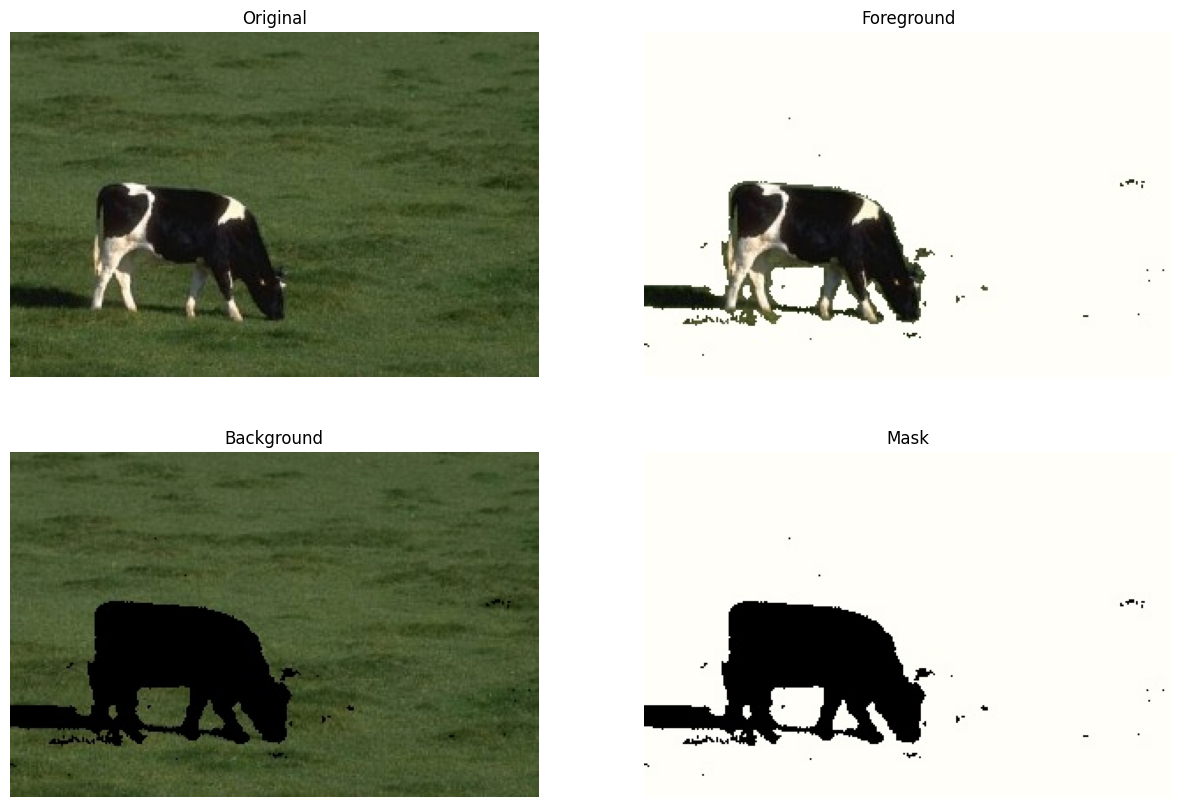

In [12]:
listOfImages = ["output/cow.jpg", "output/cow_foreground.jpg", "output/cow_background.jpg", "output/cow_masked.jpg"]
show4Images(listOfImages)

### Fox Images

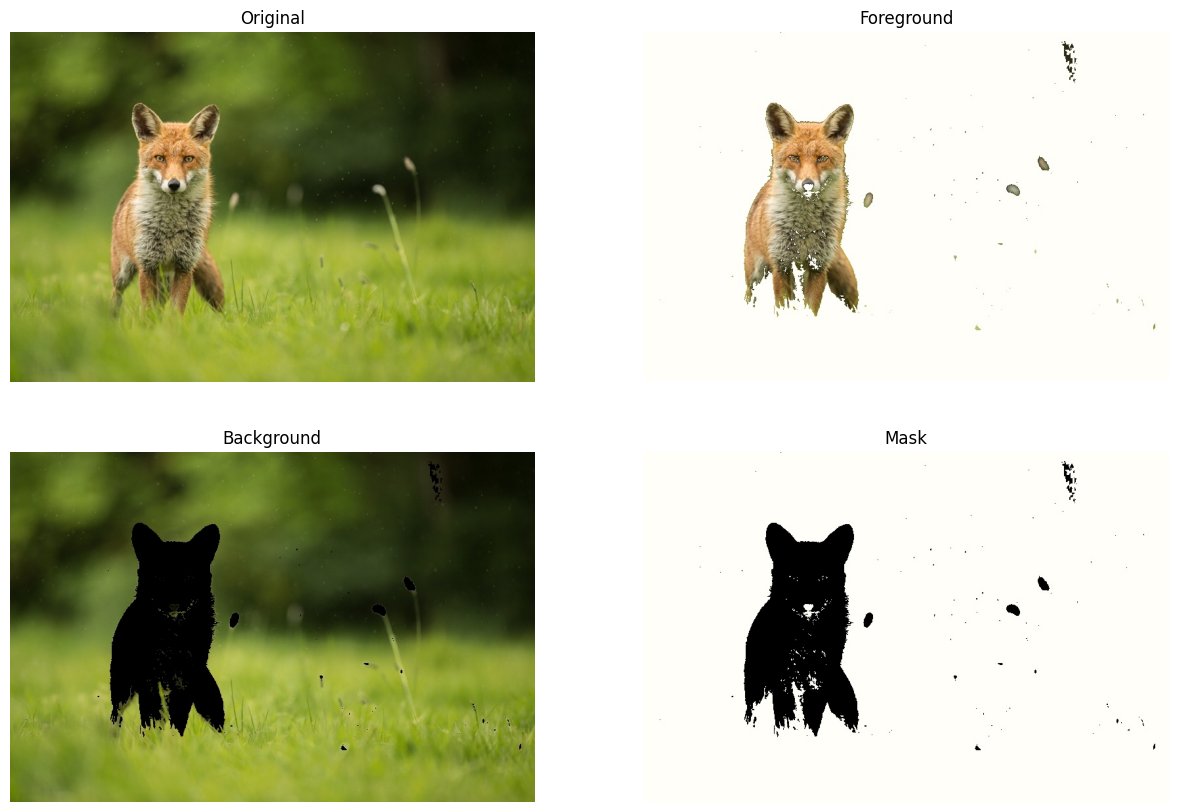

In [13]:
listOfImages = ["output/fox.jpg", "output/fox_foreground.jpg", "output/fox_background.jpg", "output/fox_masked.jpg"]
show4Images(listOfImages)

### Owl Images

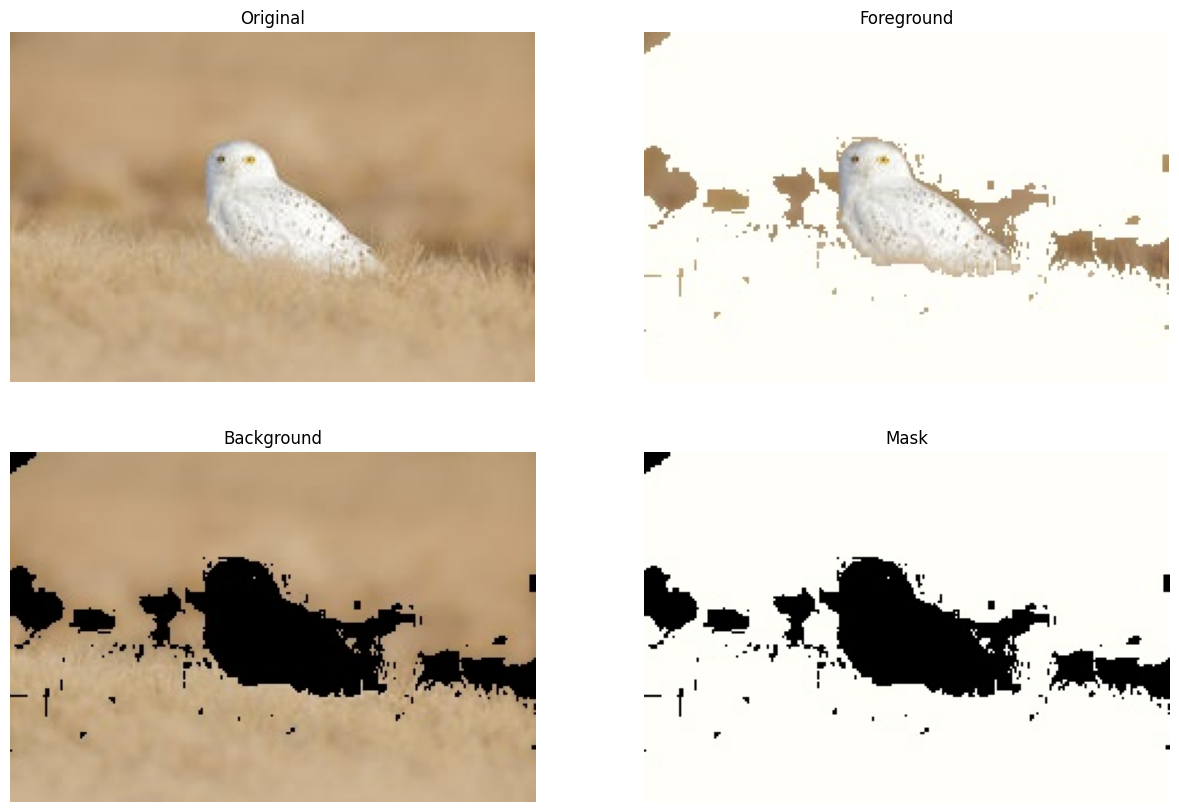

In [14]:
listOfImages = ["output/owl.jpg", "output/owl_foreground.jpg", "output/owl_background.jpg", "output/owl_masked.jpg"]
show4Images(listOfImages)

### Zebra Images

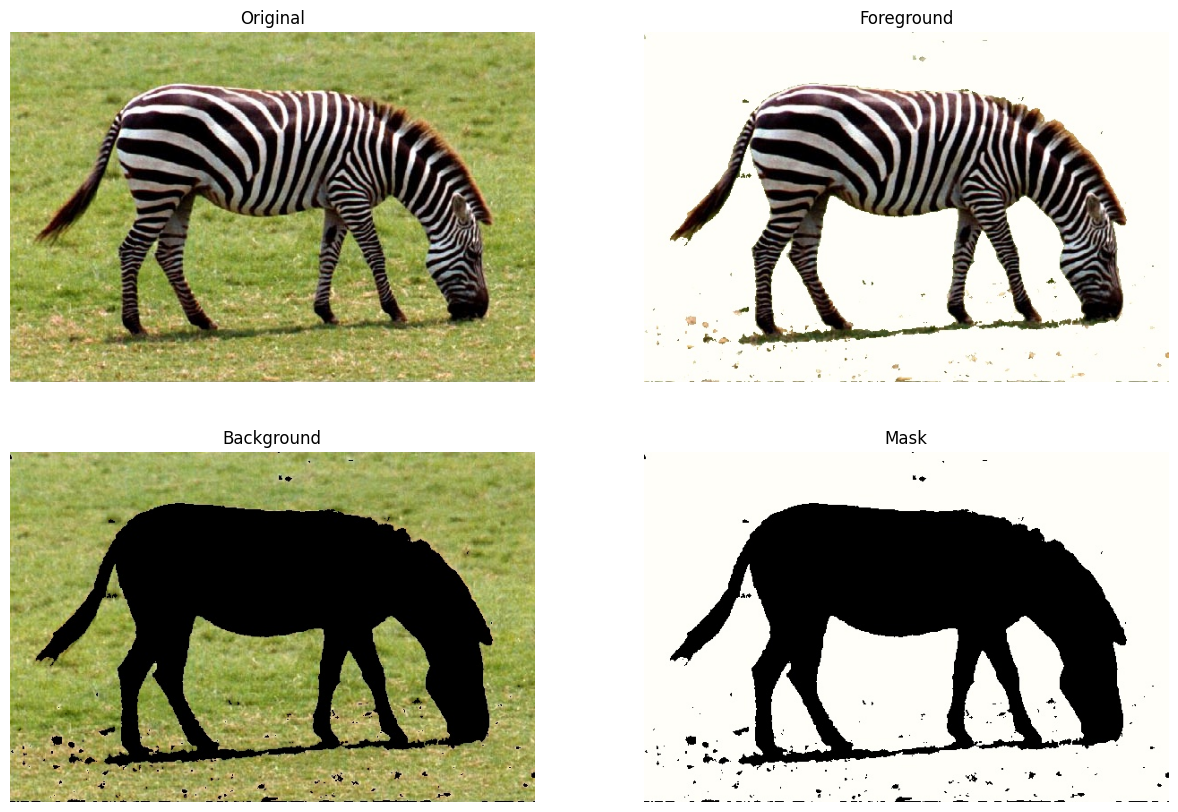

In [15]:
listOfImages = ["output/zebra.jpg", "output/zebra_foreground.jpg", "output/zebra_background.jpg", "output/zebra_masked.jpg"]
show4Images(listOfImages)

## Algorithm explanation
For the GMM initialization, I split the dataset into k-parts and calculated the mean and covariance matrix from each of the parts. Using those means and covariances, I initialized k-clusters to potentially aid in the speed of convergence.

Only the color values were used in the GMM. The color values were used since the color values are the only thing that is different between the foreground and background. It doesn't make sense to use all the values since there is no point in clustering the coordinates of the pixels.

The equations used in the GMM were all taken from the slides, except for the multivariate gaussian distribution. The multivariate gaussian distribution was taken from https://www.cs.cmu.edu/~epxing/Class/10701-08s/recitation/gaussian.pdf.

For the image generation, I first obtained the majority label since that would be the background. Knowing which is the label for the background, I then generated the foreground and background images by using the label to determine which pixels to use. 

For background, the pixels with the background label were not modified while the pixels with the foreground label is changed to (0, 0, 0). Since, according to https://cielab.io/ the black color, #000000 is (0, 0, 0). 

For foreground, the pixels with the foreground label were not modified while the pixels with the foreground label is changed to (100.00, 0, 2.96). Since, according to https://cielab.io/ the white color, #FFFFFF is (100.00, 0, 2.96).

For the image mask, the pixels with the foreground label were changed to (0, 0, 0) while the pixels with the foreground label is changed to (100.00, 0, 2.96). Since, according to https://cielab.io/ the black color, #000000 is (0, 0, 0) and the white color, #FFFFFF is (100.00, 0, 2.96).

# Bayesian Network [50 points]
Given a Bayesian network shown in Figure 3, where each random variable takes a binary state, i.e. $x_i ∈ {T, F}$. Your task is to evaluate the following five probabilities and give the probability tables:

$$p(x_1|x_5), p(x_2|x_4), p(x_3|x_2), p(x_4|x_3), p(x_5).$$

Please clearly write down all the necessary steps. (Hint: you may find a short answer, please clearly explain it.)

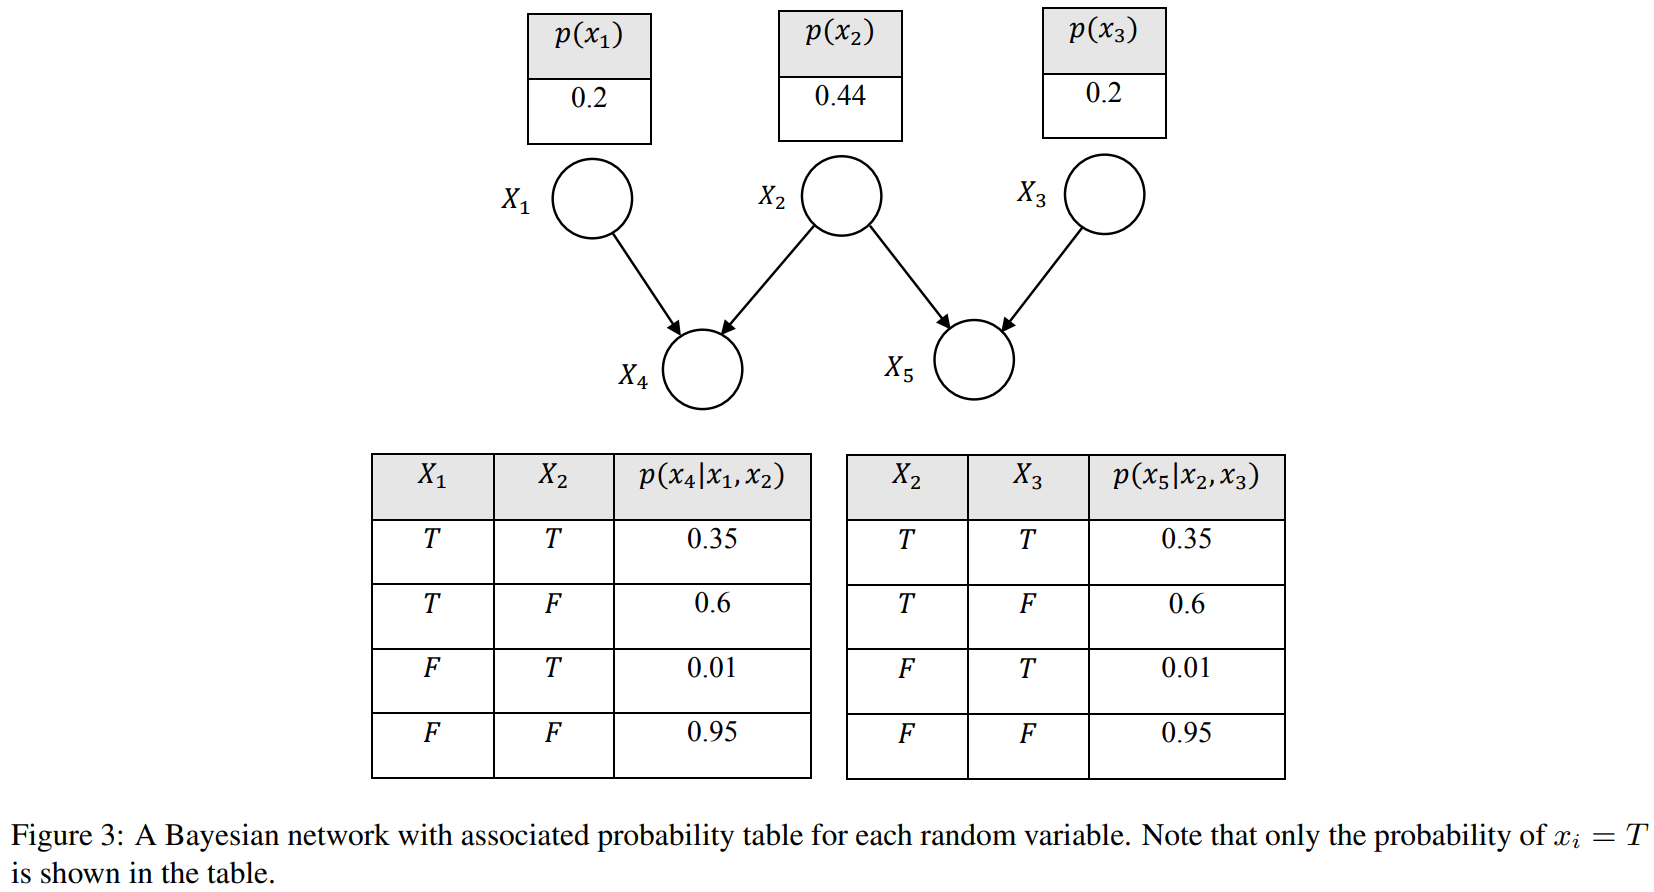

In [23]:
display(Image(filename="pics/fig3.png"))

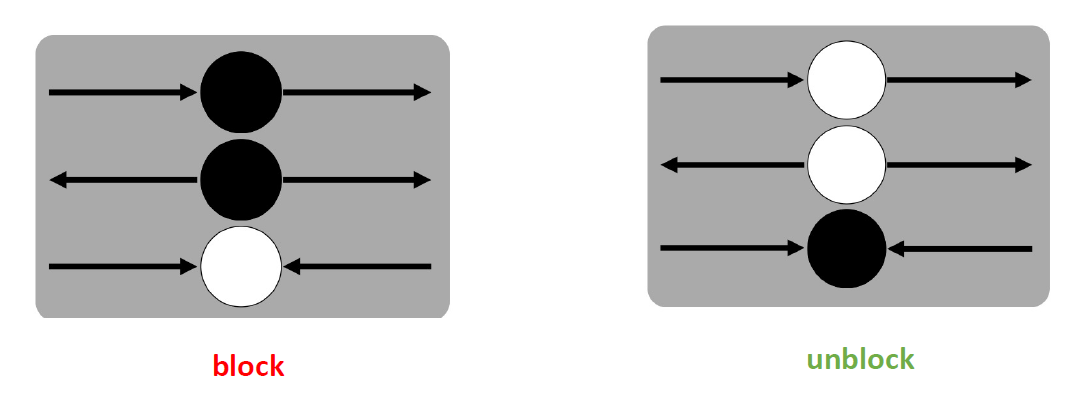

In [24]:
# source: lecture 19 slides
display(Image(filename="pics/bayesian_network_blocks.png"))

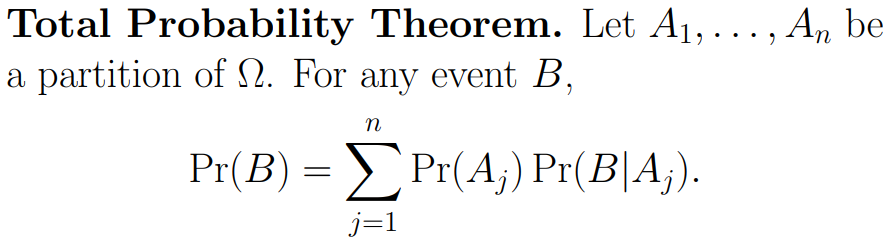

In [25]:
# source https://www.cs.cornell.edu/courses/cs280/2004sp/probability3.pdf
display(Image(filename="pics/total_probability_theorem.png"))

## Question 2 Answer

### Calculating the probability of $p(x_1 \vert x_5)$:

Using the Bayes Ball Algorithm, we can see that the ball from $x_1$ cannot pass through $x_4$ to reach $x_5$ through $x_2$ when $x_4$ is not observed. Therefore, we can conclude that $x_1$ and $x_5$ are conditionally independent in this scenario: $x_1 \perp\!\!\!\perp x_5 \vert \emptyset$.

$$p(x_1|x_5) = p(x_1)$$

$$p(x_1) = 0.2$$

$$p(x_1|x_5) = 0.2$$

Since we know that $x_1 \perp\!\!\!\perp x_5 | \emptyset$, $p(x_1 \vert x_5)$ will not change when the value if $x_5$ changes.

---

### Calculating the probability of $p(x_3 \vert x_2)$:

Using the Bayes Ball Algorithm, we can see that the ball from $x_2$ cannot pass through $x_5$ to reach $x_3$ when $x_5$ is not observed. Therefore, we can conclude that $x_2$ and $x_3$ are conditionally independent in this scenario: $x_2 \perp\!\!\!\perp x_3 | \emptyset$ .
$$p(x_3|x_2) = p(x_3)$$

$$p(x_3) = 0.2$$

$$p(x_3|x_2) = 0.2$$

Since we know that $x_2 \perp\!\!\!\perp x_3 | \emptyset$, $p(x_3 \vert x_2)$ will not change when the value if $x_2$ changes.

---

### Calculating the probability of $p(x_4 \vert x_3)$:

Using Bayes Ball Algorithm, we can see that the ball from $x_3$ cannot pass through $x_5$ to reach $x_4$ when $x_5$ is not observed. Therefore, we can conclude that $x_3$ and $x_4$ are conditionally independent in this scenario: $x_4 \perp\!\!\!\perp x_3 | \emptyset$.

$$p(x_4|x_3) = p(x_4)$$

Since the original problem is reduced to finding the probability $p(x_4)$, we can use the total probability theorem to solve this.

Given $p(x_4\vert x_1,x_2)$ and using the total probability theorem:
$$p(x_4) = \sum^{n}_{j=1}p(x_4|(x_1,x_2)_j) \cdot p((x_1,x_2)_j)$$
$\text{where } (x_1,x_2)_j \text{ is a unique combination of values for } (x_1,x_2) \text{ namely: (T,T), (T,F), (F,T), (F,F) }$

Additionally, through the Bayes Ball Algorithm, we can see that the ball from $x_1$ cannot pass through $x_4$ to reach $x_1$ when $x_4$ is not observed. Therefore, we can conclude that $x_1$ and $x_2$ are conditionally independent in this scenario: $x_1 \perp\!\!\!\perp x_2 | \emptyset$ and we can calculate $p(x_1,x_2)$ by using $p(x_1,x_2) = p(x_1)\cdot p(x_2)$.

Calculating the joint probabilities:

$p(x_1=T, x_2=T) = 0.2 \times 0.44 = 0.088$

$p(x_1=T, x_2=F) = 0.2 \times (1-0.44) = 0.112$

$p(x_1=F, x_2=T) = (1-0.2) \times 0.44 = 0.352$

$p(x_1=F, x_2=F) = (1-0.2) \times (1-0.44) = 0.448$

We can obtain the probability table of $p(x_4 \vert (x_1,x_2)) \cdot p((x_1,x_2))$ as follows:

| $X_1$ | $X_2$ | $p(x_4\|(x_1,x_2)) \cdot p((x_1,x_2))$ |
| :---: | :---: | :------------------------------------: |
|   T   |   T   |      $0.35 \times 0.088 = 0.0308$      |
|   T   |   F   |      $0.6 \times 0.112 = 0.0672$       |
|   F   |   T   |     $0.01 \times 0.352 = 0.00352$      |
|   F   |   F   |      $0.95 \times 0.448 = 0.4256$      |

Therefore, we can calculate the probability of $p(x_4)$ as follows:

$p(x_4) = 0.0308 + 0.0672 + 0.00352 + 0.4256 = 0.52712$

Since we know that $x_4 \perp\!\!\!\perp x_3 | \emptyset$, $p(x_4|x_3)$ will not change when the value if $x_3$ changes.

---

### Calculating the probability of $p(x_5)$:

Similar to the previous problem, we can use the total probability theorem to solve this.

Given $p(x_5|x_2,x_3)$ and using the total probability theorem:
$$p(x_5) = \sum^{n}_{j=1}p(x_5|(x_2,x_3)_j) \cdot p((x_2x_3)_j)$$
$\text{where } (x_2,x_3)_j \text{ is a unique combination of values for } (x_2,x_3) \text{ namely: (T,T), (T,F), (F,T), (F,F) }$

As proven above, $x_2$ and $x_3$ are conditionally independent in this scenario: $x_2 \perp\!\!\!\perp x_3 \vert \emptyset$. Thus, we can calculate $p(x_2,x_3)$ by using $p(x_2,x_3) = p(x_2)\cdot p(x_3)$.

Calculating the joint probabilities:

$p(x_2=T, x_3=T) = 0.2 \times 0.44 = 0.088$

$p(x_2=T, x_3=F) = 0.2 \times (1-0.44) = 0.112$

$p(x_2=F, x_3=T) = (1-0.2) \times 0.44 = 0.352$

$p(x_2=F, x_3=F) = (1-0.2) \times (1-0.44) = 0.448$

We can obtain the probability table of $p(x_5 \vert (x_2,x_3)) \cdot p((x_2,x_3))$ as follows:

| $X_2$ | $X_3$ | $p(x_5 \vert (x_2,x_3)) \cdot p((x_2,x_3))$ |
| :---: | :---: | :-----------------------------------------: |
|   T   |   T   |        $0.35 \times 0.088 = 0.0308$         |
|   T   |   F   |         $0.6 \times 0.112 = 0.0672$         |
|   F   |   T   |        $0.01 \times 0.352 = 0.00352$        |
|   F   |   F   |        $0.95 \times 0.448 = 0.4256$         |

Therefore, we can calculate the probability of $p(x_5)$ as follows:

$p(x_5) = 0.0308 + 0.0672 + 0.00352 + 0.4256 = 0.52712$

---

### Calculating the probability of $p(x_2 \vert x_4)$:

$$p(x_2|x_4) = \frac{p(x_4 \cap x_2) }{p(x_4)} = \frac{p(x_4|x_2) \cdot p(x_2)}{p(x_4)}$$

From the previous problem, we know that $p(x_4) = 0.52712$ and we were given $p(x_2) = 0.44$.

We can calculate $p(x_4 \vert x_2)$ by using the total probability theorem since we know that $x_1 \perp\!\!\!\perp x_2 | \emptyset$:

$$p(x_4|x_2) = \sum^{n}_{j=1} p(x_4|x_2, (x_1)_j) \cdot p((x_1)_j)$$
$\text{where } (x_1)_j \text{ is the possible values for } (x_1) \text{ namely: T, F }$

We can obtain the probability table of $p(x_4 \vert x_2)$ as follows:

| $X_2$ |               $p(x_4 \vert x_2)$               |
| :---: | :--------------------------------------------: |
|   T   | $0.35 \times 0.2 + 0.01 \times (1-0.2)= 0.078$ |
|   F   | $0.6 \times 0.2 + 0.95 \times (1-0.2) = 0.88$  |

Therefore, we can calculate the probability of $p(x_2|x_4)$ as follows:
$$p(x_2|x_4) = \frac{0.078 \cdot 0.44}{0.52712} = 0.0651 \text{ (3s.f.)}$$
$$p(x_2|\neg x_4) = \frac{0.88 \cdot 0.44}{1-0.52712} = 0.819 \text{ (3s.f.)}$$

---

## Probability Tables

| $X_5$ | $p(x_1 \vert x_5)$ |
| :---: | :----------------: |
|   T   |        0.2         |
|   F   |        0.2         |

</br>

| $X_2$ | $p(x_3 \vert x_2)$ |
| :---: | :----------------: |
|   T   |        0.2         |
|   F   |        0.2         |

</br>

| $X_3$ | $p(x_4 \vert x_3)$ |
| :---: | :----------------: |
|   T   |      0.52712       |
|   F   |      0.52712       |

</br>

| $p(x_5)$ |
| :------: |
| 0.52712  |

</br>

| $X_4$ | $p(x_2\vert x_4)$ |
| :---: | :---------------: |
|   T   |      0.0651       |
|   F   |       0.819       |


# References

https://www.cs.cmu.edu/~epxing/Class/10701-08s/recitation/gaussian.pdf

https://online.stat.psu.edu/stat505/book/export/html/636

https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf

https://cielab.io/

https://towardsdatascience.com/conditional-independence-the-backbone-of-bayesian-networks-85710f1b35b

https://www.cs.cornell.edu/courses/cs280/2004sp/probability3.pdf

https://youtu.be/U23yuPEACG0

https://youtu.be/zCWRTKnOYYg

https://youtu.be/5s7XdGacztw

https://youtu.be/8odFouBR2wE